## Net Return Maximization

<div class="alert alert-block alert-info"> <b>NOTE</b> This tutorial is experiemental. </div>

This section covers budget optimization by maximizing net returns with the insights from a fitted MMM and a user supplied LTV analysis (in channel level).

In net returns maximization, the objective function is define as

\begin{align*}
R & = \sum^K_k (\text{LTV}_k - \text{Cost per Acqusition}_k) \times \text{Attribution}_k \\
  & = \sum^K_k (\text{LTV}_k - \frac{\text{Spend}_k}{\text{Attribution}_k})  \times \text{Attribution}_k \\
  & = \sum^K_k (\text{LTV}_k \times \text{Attribution}_k  - \text{Spend}_k)
\end{align*}

In [2]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import pickle
from copy import deepcopy

from karpiu.planning.optim import NetProfitMaximizer
from karpiu.planning.common import calculate_marginal_cost, generate_cost_report
from karpiu.explainability import Attributor

pd.set_option("display.float_format", lambda x: "%.5f" % x)
np.set_printoptions(suppress=True)
pd.set_option("display.max_rows", 50)

In [3]:
%load_ext autoreload
%autoreload 2

Bring back the fitted model from previous `Quickstart` section.

In [4]:
with open("./resource/model.pkl", "rb") as f:
    mmm = pickle.load(f)

In [5]:
budget_start = pd.to_datetime("2021-01-01")
budget_end = pd.to_datetime("2021-01-31")
optim_channels = mmm.get_spend_cols()

# spend_scaler a fixed constant to reduce over-float of spend
# not that they need to be consistent with the subsequent calculation of
# post optimization metrics
spend_scaler = 1e3

In [6]:
optim_channels

['promo', 'radio', 'search', 'social', 'tv']

Given the customers life-time value (LTV), one can run the revenue maximization.

In [7]:
ltv_arr = [26.5, 46.5, 56.6, 35.8, 44.8]

In [8]:
df = mmm.get_raw_df()
init_spend_matrix = df.loc[
    (df["date"] >= budget_start) & (df["date"] <= budget_end), optim_channels
].values
init_spend_matrix.shape

(31, 5)

### Optimization with Total Budget Constraints Only

In [9]:
maximizer = NetProfitMaximizer(
    ltv_arr=ltv_arr,
    model=mmm,
    optim_channel=optim_channels,
    budget_start=budget_start,
    budget_end=budget_end,
    spend_scaler=1.0,
    response_scaler=1.0,
)
optim_spend_df = maximizer.optimize(maxiter=1000, eps=1e-3)

Iteration limit reached    (Exit mode 9)
            Current function value: -592273.5190965091
            Iterations: 1000
            Function evaluations: 155689
            Gradient evaluations: 998


In [10]:
optim_spend_matrix = maximizer.get_current_state()
init_spend_matrix = maximizer.get_init_state()

In [11]:
# total spend suggest
print("Suggested total spend: {:.0f}".format(np.sum(optim_spend_matrix)))
# total budget
print("Total Budget: {:.0f}".format(np.sum(init_spend_matrix)))

Suggested total spend: 386413
Total Budget: 490508


#### Budget Allocation

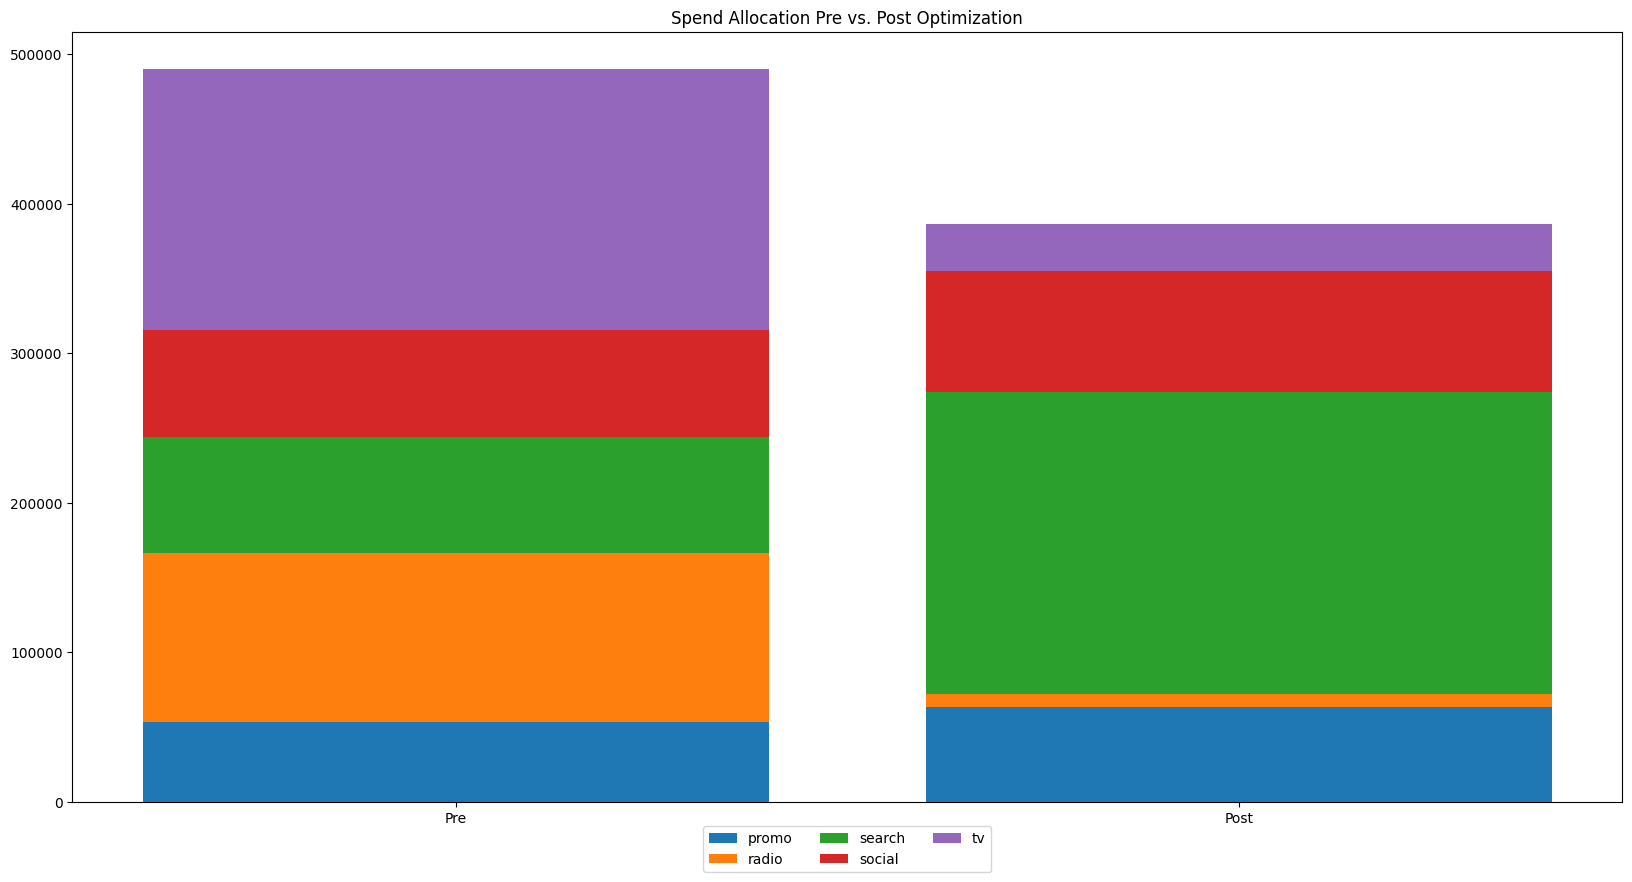

In [11]:
init_total_spend = np.sum(init_spend_matrix, 0)
optim_total_spend = np.sum(optim_spend_matrix, 0)
plot_data = np.vstack([init_total_spend, optim_total_spend])
plot_data.shape

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
bottom = 0.0
for idx, label in enumerate(optim_channels):
    ax.bar(x=["Pre", "Post"], height=plot_data[:, idx], bottom=bottom, label=label)
    bottom += plot_data[:, idx]
ax.set_title("Spend Allocation Pre vs. Post Optimization")
ax.legend(
    loc="lower center",
    bbox_to_anchor=(0.5, -0.10),
    ncol=math.ceil(len(optim_channels) / 2),
);

#### Average and Marginal Cost Change

In [12]:
df = mmm.get_raw_df()

In [13]:
cost_report = generate_cost_report(
    model=mmm,
    channels=optim_channels,
    start=budget_start,
    end=budget_end,
    pre_spend_df=df,
    post_spend_df=optim_spend_df,
)
cost_report["ltv"] = ltv_arr
cost_report

,pre-opt-avg-cost,post-opt-avg-cost,pre-opt-marginal-cost,post-opt-marginal-cost,pre-opt-spend,post-opt-spend,ltv
promo,38.86283,40.99555,42.87664,45.79833,53.30000,63.77402,26.50000
radio,79.55461,37.86914,88.34060,43.19627,112.97900,8.44898,46.50000
search,21.24898,34.00456,23.17861,36.81082,78.03300,201.66193,56.60000
social,40.12583,39.61623,43.79484,44.62521,71.64400,81.10635,35.80000
tv,65.72122,36.49072,71.33880,41.78981,174.55200,31.42189,44.80000


Because this optimization is dependent on the attribution logic, a validation suggested is to derive marginal revenue based on attribution. First, a baseline revenue is computed.

In [14]:
attr_obj = Attributor(
    mmm,
    attr_regressors=optim_channels,
    start=budget_start,
    end=budget_end,
    df=optim_spend_df,
)
res = attr_obj.make_attribution()

_, spend_attr_df, spend_df, _ = res
base_spend_attr_matrix = np.sum(spend_attr_df[optim_channels].values, 0)
base_spend_matrix = np.sum(spend_df[optim_channels].values, 0)
base_rev = base_spend_attr_matrix * (ltv_arr)
base_net_arr = base_rev - base_spend_matrix

`base_net_arr` now holds net returns for each channel. The sum would be the total baseline net returns.

In [15]:
base_net_arr.sum()

112718.85672696316

Now, one can iteratively simulate scenarios for each channel with additional spend and derive the delta of net returns between the scenario and the baseline.

In [16]:
input_mask = (optim_spend_df["date"] >= budget_start) & (
    optim_spend_df["date"] <= budget_end
)

In [17]:
delta = 1.0

In [18]:
new_revs = np.empty(len(optim_channels))
for idx, ch in enumerate(optim_channels):
    new_spend_df = deepcopy(optim_spend_df)
    delta_matrix = np.zeros_like(new_spend_df.loc[input_mask, optim_channels])
    delta_matrix[:, idx] += delta
    new_spend_df.loc[input_mask, optim_channels] += delta_matrix
    attr_obj = Attributor(
        mmm,
        attr_regressors=optim_channels,
        start=budget_start,
        end=budget_end,
        df=new_spend_df,
    )
    res = attr_obj.make_attribution()
    _, spend_attr_df, spend_df, _ = res
    new_spend_attr_matrix = np.sum(spend_attr_df[optim_channels].values, 0)
    new_spend_matrix = np.sum(spend_df[optim_channels].values, 0)
    new_rev = new_spend_attr_matrix * (ltv_arr)
    new_net_arr = new_rev - new_spend_matrix
    new_revs[idx] = new_net_arr.sum()

Now, `new_revs` net returns of each scenario with small incremental of spend of such channel.

In [19]:
new_revs

array([112698.35324432, 112719.10579968, 112710.68551908, 112701.96670989,
       112717.5442074 ])

In [20]:
new_revs - base_net_arr.sum()

array([-20.50348265,   0.24907271,  -8.17120788, -16.89001707,
        -1.31251956])

Users usually will see mostly negative delta for all scenarios otherwise a minimal positive value due to truncation.

### Run optimization with an additional constraint

`.generate_individual_channel_constraints()` is designed to help to generate convenient invidiaul budget constraints with respect to the total budget. For example, by specifying `delta=0.2`, one should expect the total resulting spend of the channel will be within $\pm 20 \%$ of the original budget.

In [21]:
maximizer2 = RevenueMaximizer(
    ltv_arr=ltv_arr,
    model=mmm,
    optim_channel=optim_channels,
    budget_start=budget_start,
    budget_end=budget_end,
    spend_scaler=10.0,
)

ind_constraints = maximizer2.generate_individual_channel_constraints(delta=0.2)
maximizer2.add_constraints(ind_constraints)
optim_spend_df2 = maximizer2.optimize(maxiter=1000, eps=1e-3)

new_cost_report = generate_cost_report(
    model=mmm,
    channels=optim_channels,
    start=budget_start,
    end=budget_end,
    pre_spend_df=df,
    post_spend_df=optim_spend_df2,
)
new_cost_report["ltv"] = ltv_arr
new_cost_report

Iteration limit reached    (Exit mode 9)
            Current function value: -51541.57857408114
            Iterations: 1000
            Function evaluations: 155376
            Gradient evaluations: 996


,pre-opt-avg-cost,post-opt-avg-cost,pre-opt-marginal-cost,post-opt-marginal-cost,pre-opt-spend,post-opt-spend,ltv
promo,38.86283,40.52310,42.87664,45.73661,53.30000,61.45701,26.50000
radio,79.55461,73.40118,88.34060,78.91913,112.97900,90.38320,46.50000
search,21.24898,23.21957,23.17861,24.92341,78.03300,93.63960,56.60000
social,40.12583,39.76191,43.79484,44.16002,71.64400,78.11986,35.80000
tv,65.72122,59.77120,71.33880,64.32155,174.55200,139.64160,44.80000
